# Selfies & ID

In this notebook, we aim to build and train a model to validate identity by comparing an uploaded ID image and a selfie. The dataset consists of selfies and ID images, and we use transfer learning with the VGG19 architecture to achieve this task.

![My Screenshot](./1690440601295.png)

In [19]:
import os
import cv2
import glob as gb
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import splitfolders
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Dataset Preparation

First, we split the dataset into training, validation, and test sets. This is done using the splitfolders library which allows for a clean separation of the data.

In [20]:
data_path = 'archive/Selfies ID Images dataset/11_sets_Hispanics'

splitfolders.ratio(data_path, output="output", seed=101, ratio=(.6, .2, .2))

Copying files: 165 files [00:00, 350.72 files/s]


In [21]:
SEED = 100
IMG_SIZE = 228
BATCH_SIZE = 75

TRAIN_DIR = './output/train'
VALID_DIR = './output/val'
TEST_DIR = './output/test'

----

## Visualizing Class Distribution

Next, we visualize the class distribution in our dataset. This helps in understanding the balance of the dataset.

/Users/pierpaolopaciello/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


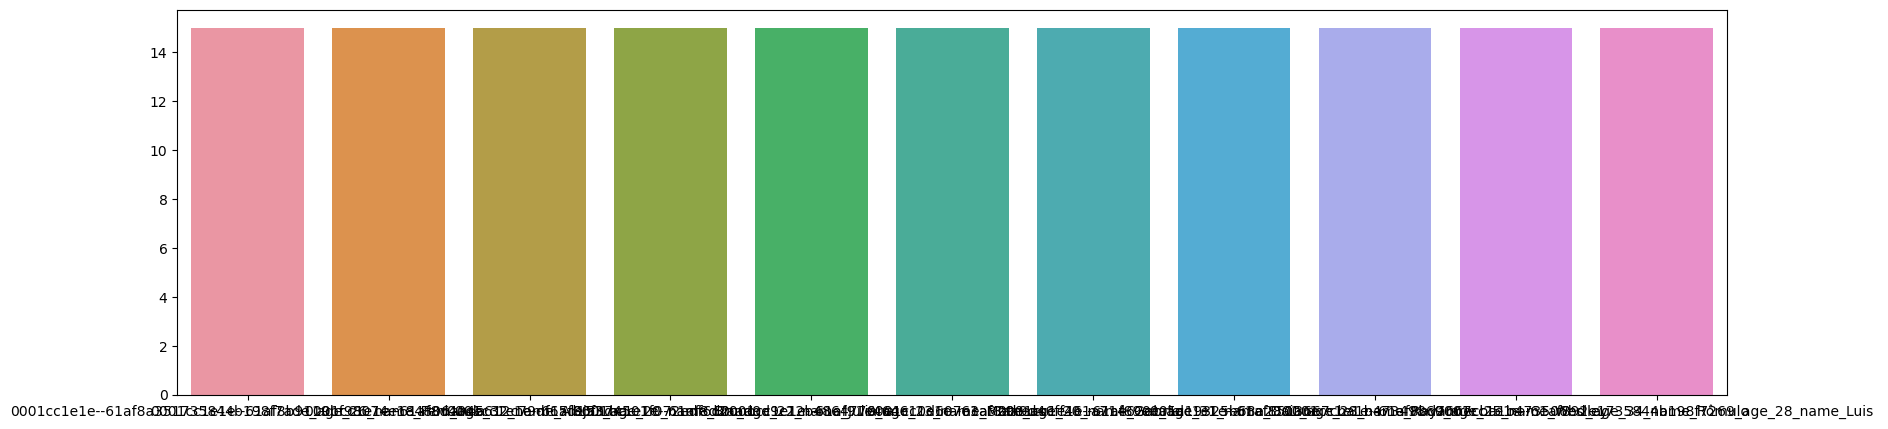

In [22]:
class_names = []
class_count = []
train_examples = 0
for f in os.listdir(TRAIN_DIR):
    files = gb.glob(pathname=str(TRAIN_DIR + "/" + f + "/*"))
    class_names.append(f)
    class_count.append(len(files))
    train_examples += len(files)
plt.figure(figsize=(20,5))
sns.barplot(x=class_names, y=class_count)
plt.show()

## Data Augmentation

We use the ImageDataGenerator to augment our training images. This helps in generating more synthetic images and prevents overfitting.

In [23]:
train_gen = ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input
)

In [24]:
train_batch = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode = 'sparse',
    seed=SEED
)

Found 165 images belonging to 11 classes.


In [25]:
valid_batch = train_gen.flow_from_directory(
    directory=VALID_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode = 'sparse',
    seed=SEED
)

Found 33 images belonging to 11 classes.


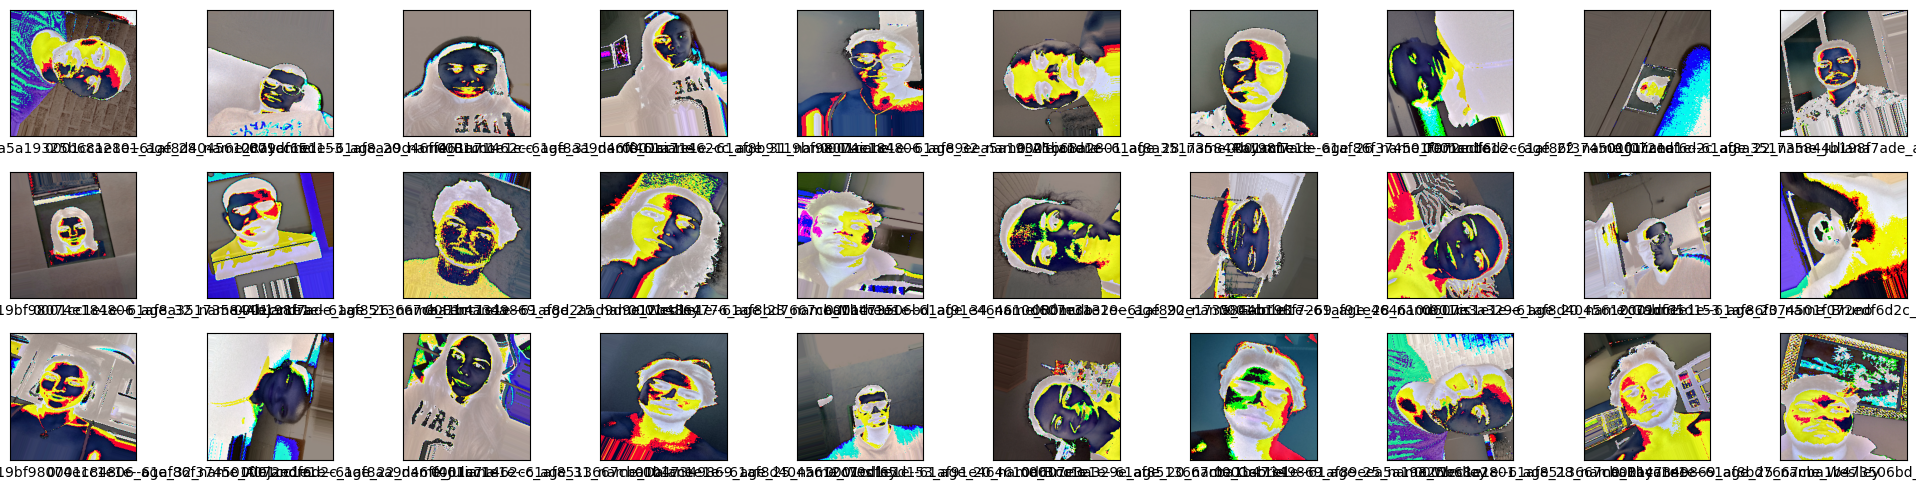

In [26]:
imgs, labels = next(train_batch)
i=0
plt.figure(figsize=(20,5))
for img,label in zip(imgs,labels):
  plt.subplot(3,10,i+1)
  plt.imshow(img.astype('uint8'))
  plt.xlabel(class_names[label.astype('int32')])
  plt.xticks([])
  plt.yticks([])
  i+=1
  if i==30:
    break
plt.tight_layout()
plt.show()

In [27]:
IMG_SHAPE = (IMG_SIZE,IMG_SIZE) + (3,)
base_model = tf.keras.applications.VGG19(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [28]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 228, 228, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 228, 228, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 228, 228, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 114, 114, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 114, 114, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 114, 114, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 57, 57, 128)       0     

In [29]:
base_model.trainable = False

## Building the Model

We use the VGG19 architecture as the base model and add custom layers on top of it. The base model is frozen to retain the pre-trained weights.

In [30]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.1)(x)
outputs = tf.keras.layers.Dense(11, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [31]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 228, 228, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 global_average_pooling2d_1  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                           

-----

## Training the Model

We compile the model with Adam optimizer and sparse categorical cross-entropy loss, and train it for 50 epochs.

In [32]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), 
    loss='sparse_categorical_crossentropy', 
    metrics=['accuracy']
)

In [33]:
import math

# Calculate steps per epoch
train_steps_per_epoch = max(1, math.ceil(165 / BATCH_SIZE))
valid_steps_per_epoch = max(1, math.ceil(33 / BATCH_SIZE))

h = model.fit(
    train_batch, 
    epochs=50,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=valid_batch,
    validation_steps=valid_steps_per_epoch
)

Epoch 1/50
3/3 [==============================] - 20s 9s/step - loss: 3.2836 - accuracy: 0.1576 - val_loss: 1.6812 - val_accuracy: 0.5152
Epoch 2/50
3/3 [==============================] - 18s 8s/step - loss: 1.6654 - accuracy: 0.4545 - val_loss: 0.6638 - val_accuracy: 0.7879
Epoch 3/50
3/3 [==============================] - 18s 5s/step - loss: 0.8276 - accuracy: 0.7636 - val_loss: 0.4421 - val_accuracy: 0.7879
Epoch 4/50
3/3 [==============================] - 18s 5s/step - loss: 0.6659 - accuracy: 0.7697 - val_loss: 0.3055 - val_accuracy: 0.9394
Epoch 5/50
3/3 [==============================] - 18s 5s/step - loss: 0.4283 - accuracy: 0.8788 - val_loss: 0.1942 - val_accuracy: 0.9394
Epoch 6/50
3/3 [==============================] - 18s 5s/step - loss: 0.2281 - accuracy: 0.9333 - val_loss: 0.0780 - val_accuracy: 1.0000
Epoch 7/50
3/3 [==============================] - 18s 5s/step - loss: 0.2418 - accuracy: 0.9212 - val_loss: 0.0409 - val_accuracy: 1.0000
Epoch 8/50
3/3 [==================

## Training Accuracy and Loss

We visualize the training accuracy and loss over the epochs.

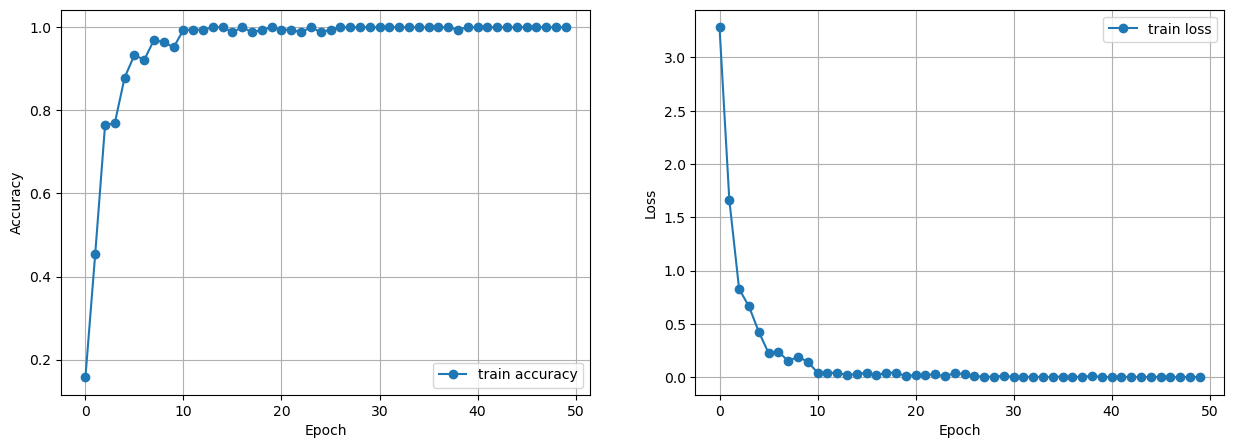

In [34]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(h.history['accuracy'], 'o-', label='train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(h.history['loss'], 'o-', label='train loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend(loc='upper right')

plt.show()

----

## Evaluating the Model

Finally, we evaluate the model on the test set to check its performance.

In [35]:
test_gen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.vgg19.preprocess_input,
    dtype=tf.float32
)

In [36]:
test_batch = train_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode = 'sparse',
    seed=SEED
)

Found 132 images belonging to 11 classes.


In [37]:
test_loss, test_acc = model.evaluate(test_batch)
print('\nTest Accuracy:', test_acc)
print('\nTest Loss:', test_loss)

2/2 [==============================] - 12s 4s/step - loss: 0.0012 - accuracy: 1.0000

Test Accuracy: 1.0

Test Loss: 0.0011748209362849593


------

## Retrain the Model with the Entire Dataset

We retrain the model with the entire dataset to improve its performance in order to deploy it in a web application.

In [38]:
data_path = 'archive/Selfies ID Images dataset/18_sets_ Caucasians'

splitfolders.ratio(data_path, output="output", seed=101, ratio=(.0, .2, .8))

TRAIN_DIR = 'archive/Selfies ID Images dataset/18_sets_ Caucasians'
VALID_DIR = './output/val'
TEST_DIR = './output/test'

Copying files: 270 files [00:00, 353.76 files/s]


/Users/pierpaolopaciello/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


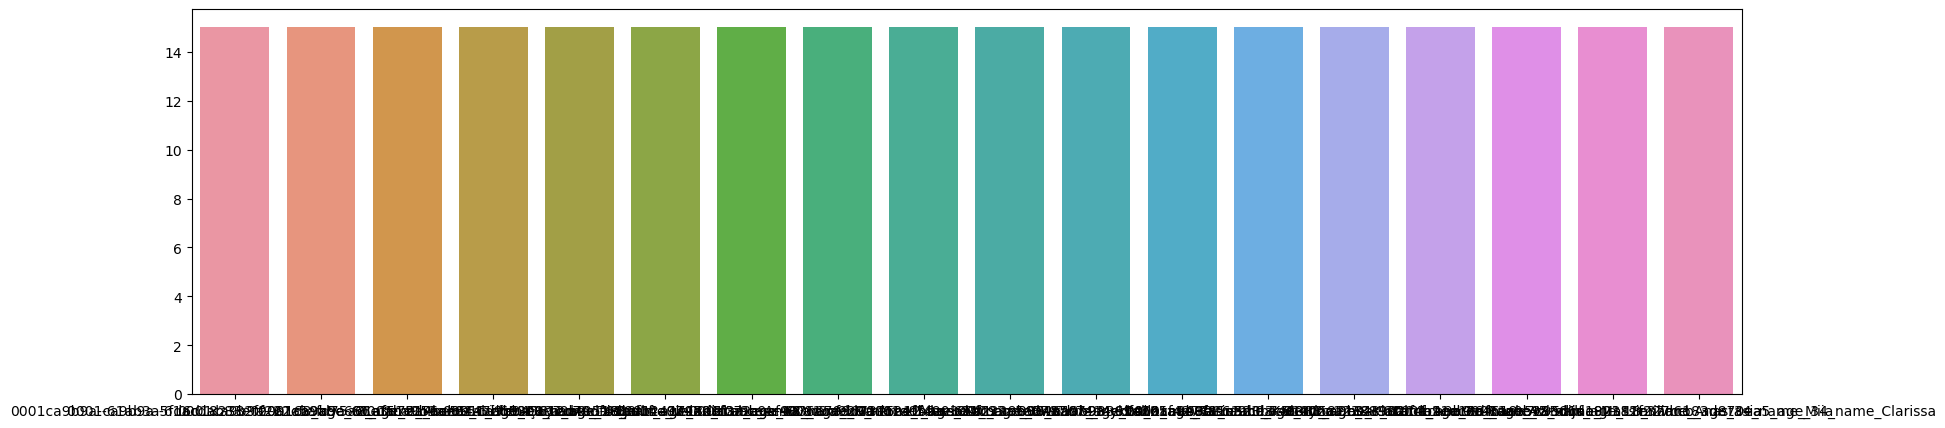

In [39]:
class_names = []
class_count = []
train_examples = 0
for f in os.listdir(TRAIN_DIR):
    files = gb.glob(pathname=str(TRAIN_DIR + "/" + f + "/*"))
    class_names.append(f)
    class_count.append(len(files))
    train_examples += len(files)
plt.figure(figsize=(20,5))
sns.barplot(x=class_names, y=class_count)
plt.show()

In [40]:
import math

# Calculate steps per epoch
train_steps_per_epoch = max(1, math.ceil(165 / BATCH_SIZE))
valid_steps_per_epoch = max(1, math.ceil(33 / BATCH_SIZE))

h = model.fit(
    train_batch, 
    epochs=10,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=valid_batch,
    validation_steps=valid_steps_per_epoch
)

Epoch 1/10
3/3 [==============================] - 20s 6s/step - loss: 0.0030 - accuracy: 1.0000 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 2/10
3/3 [==============================] - 18s 8s/step - loss: 9.6330e-04 - accuracy: 1.0000 - val_loss: 4.2973e-04 - val_accuracy: 1.0000
Epoch 3/10
3/3 [==============================] - 18s 5s/step - loss: 7.9625e-04 - accuracy: 1.0000 - val_loss: 6.5949e-05 - val_accuracy: 1.0000
Epoch 4/10
3/3 [==============================] - 18s 8s/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 1.9936e-04 - val_accuracy: 1.0000
Epoch 5/10
3/3 [==============================] - 18s 5s/step - loss: 0.0024 - accuracy: 1.0000 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 6/10
3/3 [==============================] - 18s 8s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.2809e-04 - val_accuracy: 1.0000
Epoch 7/10
3/3 [==============================] - 18s 8s/step - loss: 7.7763e-04 - accuracy: 1.0000 - val_loss: 4.3452e-04 - val_accuracy: 1.0000
Ep

## Save the Model

Finally, we save the model to disk for deployment.

In [41]:
model.save('trained_model.h1')

INFO:tensorflow:Assets written to: trained_model.h1/assets


INFO:tensorflow:Assets written to: trained_model.h1/assets
